# Building EO training/validation/testing datasets with the Sentinelhub API

#### The following modules/Libraries will be needed

In [17]:
from sentinelhub import BBox, CRS, DataCollection, SHConfig, WmsRequest, WcsRequest, DataSource, MimeType
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import rasterio
import numpy as np
import datetime

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options. You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

Generate a configuration:
This is done using the ID.
This is so that sentinelhub knows you are authorised to use their service, and which parts of the service you want to use.

In [18]:
INSTANCE_ID = '42345776-19b9-4c80-970d-893dea504aad'
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

print(config)

{
  "instance_id": "42345776-19b9-4c80-970d-893dea504aad",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}


Define a region and a random test date 

In [65]:
# Seymour Basin, Vancouver
# 49.468239,-122.981055,
# 49.482600,-122.958867

# Nepal,Everest



# lat, long
s, w = 49.468239,-122.981055
n, e = 49.482600,-122.958867

aoi = [w, s, e, n]

# Create a bounding box and assign CRS
aoi_coords = BBox(bbox=aoi, crs=CRS.WGS84)


# Choose a date 
# for loop with try except for a range of dates, so that if data is unavailable it skips that day

In [84]:
import pandas as pd
sdate = date(2020,5,1)   # start date
edate = date(2020,10,30)   # end date
dates_list = pd.date_range(sdate,edate-timedelta(days=1),freq='d')
print(dates_list)

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23',
               '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27',
               '2020-10-28', '2020-10-29'],
              dtype='datetime64[ns]', length=182, freq='D')


In [90]:
for i in dates_list:
    wcs_true_color_request.get_dates = WcsRequest (
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='TRUE-COLOR-S2-L2A', # Layer you have configured
    bbox=aoi_coords, 
    time= i,
    resx='10m', # Stick to 10m resolution as this the maximum possible 
    resy='10m', 
    config=config,
    maxcc=0.2 # You can define the maximum ammount of cloud coverage you want to allow. 
    )

basemap = wcs_true_color_request.get_data()[0]
print('Returned data is of type = %s and length %d.' % (type(basemap), len(basemap)))
# print('Single element in the list is of type {} and has shape {}'.format(type(wms_true_color_img[-1]),
                                                                        # wms_true_color_img[-1].shape))


# print(f'Dimensions: {basemap.shape}')

fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.imshow(basemap)
plt.axis('off')
plt.show()         

IndexError: list index out of range

In [91]:
# make the request for the desired date range 
wcs_true_color_request = WcsRequest (
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='TRUE-COLOR-S2-L2A', # Layer you have configured
    bbox=aoi_coords, 
    time= ('2020-05-01','2020-10-30'),
    resx='10m', # Stick to 10m resolution as this the maximum possible 
    resy='10m', 
    config=config,
    maxcc=0.2 # You can define the maximum ammount of cloud coverage you want to allow. 
    )

# use get_dates() func to get available Sentinel data
available_data_list = wcs_true_color_request.get_dates()


for i in available_data_list:
    wcs_true_color_request = WcsRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='TRUE-COLOR-S2-L2A', # Layer you have configured
    bbox=aoi_coords, 
    time= i,
    resx='10m', # Stick to 10m resolution as this the maximum possible 
    resy='10m', 
    config=config,
    maxcc=0.1 # You can define the maximum ammount of cloud coverage you want to allow. 
    )

    
basemap = wcs_true_color_request.get_data()[0]
# [0]
print('Returned data is of type = %s and length %d.' % (type(basemap), len(basemap)))
# print('Single element in the list is of type {} and has shape {}'.format(type(wms_true_color_img[-1]),
                                                                        # wms_true_color_img[-1].shape))


# print(f'Dimensions: {basemap.shape}')

fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.imshow(basemap)
plt.axis('off')
plt.show()       

IndexError: list index out of range

If you just wanted to download a true colour composite, you could use WcsRequest()

If you want to access the full Sentinel-2 product (with all channels) you can use wms request. 

In [21]:
# Define the Web map server request 
wms_bands_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='BANDS-S2-L2A', # We are using the 'BANDS-S2-L2A layer now'
    bbox=aoi_coords, 
    time=test_date,
    width=basemap.shape[1], # 10m resolution dims are sourced from the basemap. 
    height=basemap.shape[0],
    image_format=MimeType.TIFF, 
    config=config
)

# Extract the bands.
bands = wms_bands_request.get_data()[-1]
bands = bands.astype('float32') 
print(bands.shape)

# We can extract the bands to make them easier to work with.
b01 = bands[:,:,0] # Coastal Aerosol
b02 = bands[:,:,1] # Blue
b03 = bands[:,:,2] # Green
b04 = bands[:,:,3] # Red
b05 = bands[:,:,4] # Vegetation Red Edge 
b06 = bands[:,:,5] # Vegetation Red Edge
b07 = bands[:,:,6] # Vegetation Red Edge
b08 = bands[:,:,7] # NIR
b08a = bands[:,:,8] # Vegetation Red Edge
b09 = bands[:,:,9] # Water Vapour
b11 = bands[:,:,10] # SWIR
b12 = bands[:,:,11] # SWIR

# To see how each of these channels look we can plot them out.
fig, ax = plt.subplots(2, 6, figsize=(15,6))
ax[0, 0].imshow(b01, cmap='cubehelix')
ax[0, 0].set_title('Coastal Aerosol')
ax[0, 0].axis('off')
ax[0, 1].imshow(b02, cmap='cubehelix')
ax[0, 1].set_title('Blue')
ax[0, 1].axis('off')
ax[0, 2].imshow(b03, cmap='cubehelix')
ax[0, 2].set_title('Green')
ax[0, 2].axis('off')
ax[0, 3].imshow(b04, cmap='cubehelix')
ax[0, 3].set_title('Red')
ax[0, 3].axis('off')
ax[0, 4].imshow(b05, cmap='cubehelix')
ax[0, 4].set_title('Vegetation Red Edge ')
ax[0, 4].axis('off')
ax[0, 5].imshow(b07, cmap='cubehelix')
ax[0, 5].set_title('Vegetation Red Edge ')
ax[0, 5].axis('off')
ax[1, 0].imshow(b08, cmap='cubehelix')
ax[1, 0].set_title('Vegetation Red Edge ')
ax[1, 0].axis('off')
ax[1, 1].imshow(b08a, cmap='cubehelix')
ax[1, 1].set_title('NIR')
ax[1, 1].axis('off')
ax[1, 2].imshow(b09, cmap='cubehelix')
ax[1, 2].set_title('Vegetation Red Edge')
ax[1, 2].axis('off')
ax[1, 3].imshow(b11, cmap='cubehelix')
ax[1, 3].set_title('SWIR')
ax[1, 3].axis('off')
ax[1, 4].imshow(b12, cmap='cubehelix')
ax[1, 4].set_title('SWIR')
ax[1, 4].axis('off')
ax[1, 5].imshow(basemap, cmap='cubehelix')
ax[1, 5].set_title('True Colour composite')
ax[1, 5].axis('off')
plt.show()

NameError: name 'basemap' is not defined

We can  then use band 2 and band 11 (SWIR and Blue) to create a normalised difference snow index (NDSI) and the normalised difference water index

In [7]:
# A guide for Spectral indicies:
# https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data

# Normalised difference snow index 
NDSI = (b03 - b11)/(b03 + b11)

# Normalised difference water index 
NDWI = (b03 - b08)/(b03 + b08)

I chose a region where both water and snow are present. 
This shows that when trying to isolate snow, we also isolate water. 

But when isolating water, we, the snow is mostly left out.
This means that we can use both indicies to generate some training data

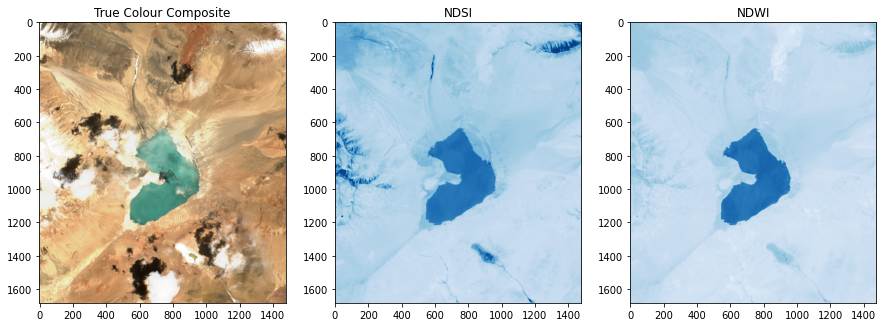

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
# ax.imshow(basemap)
ax[0].imshow(basemap)
ax[0].set_title('True Colour Composite')

ax[1].imshow(NDSI, cmap='Blues')
ax[1].set_title('NDSI')

ax[2].imshow(NDWI, cmap='Blues')
ax[2].set_title('NDWI')

plt.savefig('NDSI.png', dpi=600)
plt.show()

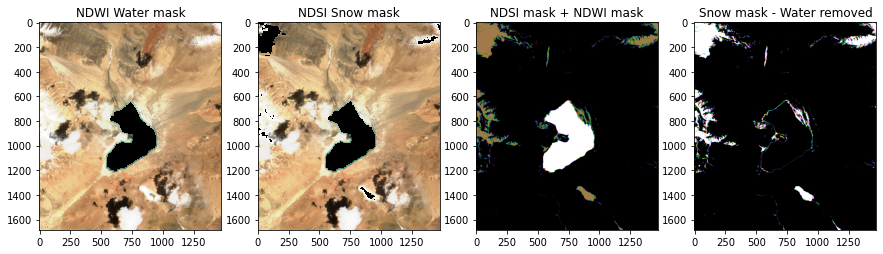

In [9]:
def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
NDWI_mask = to_mask(NDWI, 0.2)
NDSI_mask = to_mask(NDSI, 0.)
fig, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].set_title('NDWI Water mask')
ax[0].imshow(basemap)
ax[0].imshow(NDWI_mask, cmap='cubehelix')
ax[1].set_title('NDSI Snow mask')
ax[1].imshow(basemap)
ax[1].imshow(NDSI_mask, cmap='cubehelix')

NDWI_binary_mask = np.nan_to_num(NDWI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
both = NDWI_binary_mask + NDSI_binary_mask

ax[2].set_title('NDSI mask + NDWI mask')
ax[2].imshow(both, cmap='cubehelix')

ax[3].set_title('Snow mask - Water removed')
snow_only = both.copy()
snow_only[snow_only == 2] = 0
ax[3].imshow(snow_only, cmap='cubehelix')

CNN's usually don't accept big inputs, so the image needs to be cropped into smaller samples.

The bigger and more complex the CNN, the more processing power will be required, therefore the smaller the input samples will need to be. 

Rather than crushing the original sample, a good idea is to splice it. 
This way we get a lot more data, and the 10m resolution is maintained. 

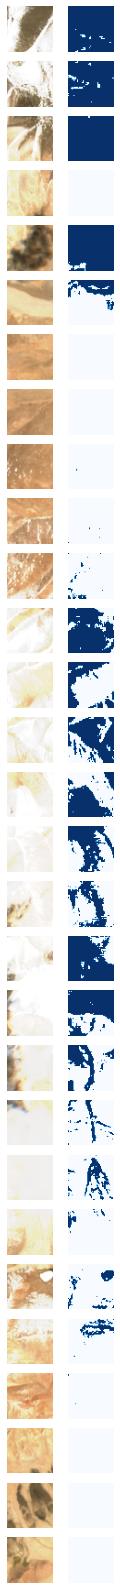

In [10]:
import math

# Split the Images
def split_image(dim_pix, im):
    # Find the number of sub-Images that fit in rows
    rows = []
    tiles = []
    for i in range((math.floor(im.shape[0] / dim_pix))):
        rows.append(i)
    # Find the number of sub-Images that fit in rows
    columns = []
    for i in range((math.floor(im.shape[1] / dim_pix))):
        columns.append(i)

    # Numerically identify the sub-Images
    a = 0
    for i in rows:
        for j in columns:
            # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
            if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[0]) == dim_pix:
                if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[1]) == dim_pix:

                    tile = im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                            0 + dim_pix * i: dim_pix + (dim_pix * i)]

                    # Stop white tiles for positive results
                    count = np.count_nonzero(tile == 1) == (dim_pix * dim_pix)
                    if count:
                        all_black = np.tile(1, (dim_pix, dim_pix))
                        tiles.append(tile)
                    else:
                        tiles.append(tile)
                    a += 1
                else:
                    print("Out of shape")
        return tiles

input_tensor_dimensions = 50
                    
basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=basemap)
label_tiles = split_image(dim_pix=input_tensor_dimensions, im=snow_only)

fig, ax = plt.subplots(len(label_tiles), 2, figsize=(2 ,len(label_tiles)))
for index in range(len(label_tiles)):
    ax[index, 0].axis('off')
    ax[index, 1].axis('off')
    ax[index, 0].imshow(basemap_tiles[index])
    ax[index, 1].imshow(label_tiles[index], cmap='Blues')